In [1]:
## Face detection and recognition using facenet-pytorch library
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

workers = 0 if os.name == 'nt' else 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Define Models

In [64]:
mtcnn = MTCNN(
    image_size=160, margin=30, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2',num_classes=1004,classify=True).eval().to(device)

In [65]:
resnet.load_state_dict(torch.load('finetuned_youtube_dataset_noscheduler.pth'))

<All keys matched successfully>

In [66]:
# constants
batch_size = 32

In [67]:


class FaceLibraryDataset(Dataset):
    def __init__(self,root,transform=None):
        self.root = root
        self.transform=transform
        self.file_names = [f for f in os.listdir(root) if self._know_ext(f)]
        self.images = []

    def _know_ext(self,fname):
        ext = fname.split('.')[-1]

        if ext == 'jpeg' or ext=='png' or ext=='PNG' or ext=='jpg':
            return True
        else:
            return False

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self,idx):
        fname = self.file_names[idx]
        img = Image.open(os.path.join(self.root,fname)).convert('RGB').resize((160,160))
        # import pdb;pdb.set_trace()
        return transforms.ToTensor()(img),fname.split('.')[0]


        

class FaceLibrary:
    def __init__(self,root,detector,feature_extractor,device):
        # FaceLibrary().__init__()
        self.root = root
        # self.dataloader = dataloader
        self.detector = detector
        self.feature_extractor = feature_extractor
        
        self.face_crops = []
        self.face_embeddings = []
        self.face_names = []

        self.device = device

        # self._detect_faces()
        self._extract_embeddings()
        print("initiated")
    
    def _detect_faces(self):
        
        for idx,(x,name) in enumerate(self.dataloader):
            x = x.to(self.device)
            faces = self.detector(x)

            self.face_crops.append(faces)
            # self.face_names.append(name)
        
        import pdb;pdb.set_trace()


    def _extract_embeddings(self):
        
        # import pdb;pdb.set_trace()
        # for cropped in self.face_crops:
        #     embd  = self.feature_extractor(cropped)
        #     self.face_embeddings.append(embd)

        # import pdb;pdb.set_trace()
        images = os.listdir(self.root)
        face_images = []
        for face_img in images:
            name,ext = face_img.split('.')
            if ext != 'jpg' and ext!='PNG' and ext!='png' and ext!='jpeg':
                print('[Skip] Unknown extension for %s' % name)
            else:
                # print("[%s] processed" % name)
                self.face_names.append(name)
                img = Image.open(os.path.join(self.root,face_img)).convert('RGB')
                
                cropped = self.detector(img)
                face_images.append(cropped.unsqueeze(dim=0))
                # TODO: load face image
                face_images.append(transforms.ToTensor()(Image.open(os.path.join(self.root,face_img)).convert('RGB').resize((160,160))).unsqueeze(dim=0))
                print('Added %s to embedding list' % name)
        
        faces = torch.cat(face_images).to(self.device) #face_images.stack(face_images).to(self.device)
    
        self.face_embeddings = self.feature_extractor(faces)
        print('Done Processing all faces in library')
    
    def find_closest_match(self,face,return_all=False):
        face_embd = self.feature_extractor(face)
        dists = []
        best_dist = None
        best_name = None
        for name,embd in zip(self.face_names,self.face_embeddings):
            # import pdb;pdb.set_trace()
            dist = (face_embd-embd).norm().item()
            dists.append(dist)
            if best_dist is None or dist<best_dist:
                best_name = name
                best_dist = dist

        if return_all:
            return best_name,best_dist,dists
        else:
            return best_name,best_dist

                

In [68]:
# face_lib_dataset = FaceLibraryDataset(root='/home/spock-the-wizard/cmu/project/library')
# face_lib_dataloader = DataLoader(face_lib_dataset,batch_size=16,shuffle=False)
face_lib = FaceLibrary(root='/home/ubuntu/visual_search_assistant/demo_library/demo_library_US',detector=mtcnn,feature_extractor=resnet,device=device)

Added Brian_Cox to embedding list
Added Quincy_Isaiah to embedding list
Added Samuel_L_Jackson to embedding list
Added Tom_Hiddleston to embedding list
Added lacey_rose to embedding list
Added Michael_Keaton to embedding list
Added oscar_issac to embedding list
Done Processing all faces in library
initiated


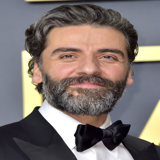

('Tom_Hiddleston',
 87.09638214111328,
 [94.23546600341797,
  90.1461410522461,
  103.04442596435547,
  87.09638214111328,
  98.4913558959961,
  99.7940444946289,
  108.83578491210938])

In [69]:
# Test with sample image of tom cruise
# transforms.ToTensor()(Image.open(os.path.join(self.root,face_img)).resize((160,160))).unsqueeze(dim=0)
test_face = Image.open('/home/ubuntu/visual_search_assistant/demo_library/demo_library_US/oscar_issac.jpeg').convert('RGB').resize((160,160))
display(test_face)
test_face = transforms.ToTensor()(test_face).unsqueeze(dim=0).to(device)
# print(test_face.shape)
face_lib.find_closest_match(test_face,return_all=True)

In [70]:
def write_out_video(cap,frames,bboxes,names=None):
    # print(len(frames),len(bboxes),len(names))
    for frame,bbox,name in zip(frames,bboxes,names):
        frame = np.asarray(frame)
        frame=cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) 
        if bbox is not None:
            left,bottom,right,top = bbox[0] #(top,bottom,right,left) = bbox[0]
            top = int(top)
            bottom = int(bottom)
            right = int(right)
            left = int(left)
            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            if name is not None:
                # write text                
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
        cap.write(frame)

    

In [71]:
def write_single_face(frame,box,name):
    """frame: cv2 image"""
    
    left,bottom,right,top = box
    # draw bbox
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
            # Draw a label with a name below the face
    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
    
    return frame

In [72]:
video_pth = '/home/ubuntu/visual_search_assistant/demo_video/demo_US_clip.mp4'
video = cv2.VideoCapture(video_pth)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(video.get(3))
frame_height = int(video.get(4))

output_video_pth = '/home/ubuntu/visual_search_assistant/demo_video/result_US.mp4'
out_video = cv2.VideoWriter(output_video_pth,cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 25, (frame_width,frame_height))
frames = []
skip_frame = False
for i in tqdm(range(total_frames)):
    success,frame = video.read()

    if not success or i==1000:
        print('Done Processing after %d frames' % i)
        break
    skip_frame = not skip_frame
    if not skip_frame:
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frames.append(frame)
        if i% 100 == 0:
            print('Frame count %d' % i)
        if len(frames)==batch_size:
            batched_boxes,batched_probs = mtcnn.detect(frames)
            for fr,boxes,probs in zip(frames,batched_boxes,batched_probs):
                
                # convert to cv2 image
                frame = np.asarray(fr)
                frame=cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) 

                if boxes is not None:
                    for box,prob in zip(boxes,probs):
                        box = box.astype(np.int32)
                        left,bottom,top,right = box
                        
                        new_width = (right-left)*1.0
                        new_height = (top-bottom)*1.0
                        center = (left+right)/2,(top+bottom)/2
                        
                        new_left = center[0] - new_width/2
                        new_right = center[0] + new_width/2
                        new_top = center[1] + new_height/2
                        new_bottom = center[1] - new_height/2
                        new_box = np.array([new_left, new_bottom, new_top, new_right]).astype(np.int32)
                        
                        cropped = fr.crop((new_left,new_bottom,new_top,new_right))
                        cropped.save('img/'+str(prob)[2:]+'.jpg')
#                         raise NotImplementedError
                        face = transforms.ToTensor()(cropped.resize((160,160))).unsqueeze(dim=0).to(device)
                        name,dist = face_lib.find_closest_match(face)
                        frame = write_single_face(frame,new_box,name)
                
                out_video.write(frame)
            frames = []

    
video.release()
out_video.release()


100%|██████████| 696/696 [00:55<00:00, 12.47it/s]
